In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pandas as pd
import numpy as np
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

sns.set()
sns.set_style("ticks")
# sns.set(rc={'axes.facecolor':'#1E1E1E', 'figure.facecolor':'#1E1E1E'})

import tskit
from collections import defaultdict

from chromwindow import window
from switchprobs import sample_switch_sets, cut_intervals

# # scale down size of default plots
# sns.set_context("paper")
# import matplotlib as mpl
# scale = 0.8
# d = dict([(k, v*scale) for (k, v) in sns.plotting_context('paper').items()])
# d['figure.figsize'] = [5.4, 3.5]
# mpl.rcParams.update(d)

In [29]:
# tree_seq = tskit.load('chromhapX.trees')
tree_seq = tskit.load('chromX_tskit.trees')
# for tree in tree_seq.trees():
#     print(tree)
#     break

print(tree_seq.samples())
print(195 // 2)
sample_df = pd.read_csv('pops/all_females_8cluster.sample', sep=' ')
sample_df.head()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
97


ID             POP           GROUP     SEX
0  Sci_16066  Eastern_Yellow  Eastern_Yellow  female
1  Sci_16098  Eastern_Yellow  Eastern_Yellow  female
2  Sci_34449          Kindae          Kindae  female
3  Sci_34474          Kindae          Kindae  female
4  Sci_97074       Hamadryas       Hamadryas  female

In [32]:
sample_df.POP.unique()

array(['Eastern_Yellow', 'Kindae', 'Hamadryas', 'Tanzanian_Olive',
       'Western_Yellow', 'Papio', 'Chacma', 'Ethiopian_Olive'],
      dtype=object)

In [41]:
labels = []
north_pops = ['Papio', 'Hamadryas', 'Ethiopian_Olive',  'Tanzanian_Olive']
for sample_idx in tree_seq.samples():
    # labels.append(int(sample_df.loc[sample_idx//2, 'POP'] in north_pops))
    labels.append(int(sample_df.loc[sample_idx, 'POP'] in north_pops))
len(labels)

#labels = [0] * len(labels)

42

/Users/kmt/miniconda3/envs/switch-probs/lib/python3.8/site-packages/tskit/drawing.py:1311: FutureWarning: tree_height_scale is deprecated; use time_scale instead
  warnings.warn(


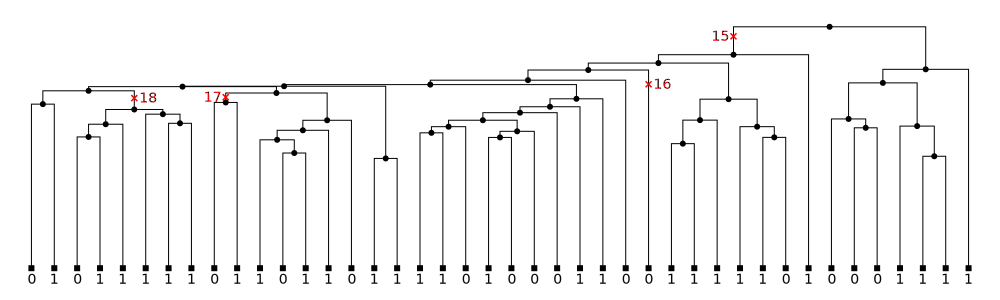

In [42]:
ts = tree_seq.trees()
tree = next(ts)
tree = next(ts)
tree.draw_svg(size=(1000, 300), tree_height_scale='log_time',
node_labels=dict(zip(range(len(labels)), labels))
 )

In [177]:


# tree = tskit.Tree.generate_random_binary(9, random_seed=3)

# tree = tskit.Tree.generate_balanced(9, arity=2)
# labels = np.array([0, 0, 0, 0, 1, 1, 1, 1, 0])

# n = 20
# tree = tskit.Tree.generate_balanced(n, arity=2)
# leaves = list(range(n))
# labels = np.array([0] * 10 + [1] * 10)

# # for i in range(0, 20, 2):
# #     labels[i] = 1

# # labels[0] = 1

# labels[5] = 1
# labels[6] = 1

# tree = tskit.Tree.generate_balanced(5, arity=2)
# labels = np.array([1, 1, 0, 1, 1])

# print(tree.draw_text())

# labels = []
# north_pops = ['Papio', 'Hamadryas', 'Ethiopian_Olive',  'Tanzanian_Olive']
# for sample_idx in tree_seq.samples():
#     labels.append(int(sample_df.loc[sample_idx//2, 'POP'] in north_pops))

nr_trees = 300

records = list()

for tree in tree_seq.trees():

    if not nr_trees:
        break
    nr_trees -= 1


    tree_start_pos, tree_end_pos = tree.interval

    # part_fun = partial(fun, switch_rate=0.001,
    #    left_child_array=tree.left_child_array,
    #    right_child_array=tree.right_child_array, 
    #    parent_array=tree.parent_array,
    #    num_children_array=tree.num_children_array)
    # part_fun = partial(fun, switch_rate=0.001, tree=tree)

    # print(np.array(range(len(labels))))
    # print(labels)

    # samples = sample_switch_sets(tree, labels, n_samples=100, switch_rate=0.00001)
    samples = sample_switch_sets(tree, labels, n_samples=100, switch_rate=0.0001)
    # for val, interv, key in samples:
    #     print(val, interv, key)

    intervals = []
    for val, interv, key in samples:
        for start, end, label in interv:
            if start == 0:
                intervals.append([0, np.log10(end), key, label])
            else:
                intervals.append([np.log10(start), np.log10(end), key, label])
    intervals = sorted(intervals)


    @window(size=0.1)
    def switches(df):
        return df.switches.mean()

    df = pd.DataFrame().from_records(intervals, columns=['start', 'end', 'switches', 'label'])
    binned_intervals = df.groupby('label').apply(switches).reset_index(level=0)
    bins = defaultdict(float)
    for tup in binned_intervals.itertuples():
        bins[(tup.start, tup.end, tup.label)] += tup.switches

    # binned_intervals = cut_intervals(intervals, windowsize=2)
    # bins = defaultdict(float)
    # for start, end, prob, label in binned_intervals:
    #     bins[(start, end, label)] += prob

    mrca_tree = tree.time(tree.root)
    # mrca_0 = tree.time(tree.mrca(*[x for x in sample_df.index if labels[x] == 0]))
    # mrca_1 = tree.time(tree.mrca(*[x for x in sample_df.index if labels[x] == 1]))
    mrca_0 = tree.time(tree.mrca(*[x for x in tree_seq.samples() if labels[x] == 0]))
    mrca_1 = tree.time(tree.mrca(*[x for x in tree_seq.samples() if labels[x] == 1]))

    for key in sorted(bins.keys()):
        records.append((tree_start_pos, tree_end_pos, *key, round(bins[key], 5), mrca_tree, mrca_0, mrca_1))

test_df = pd.DataFrame().from_records(records,
    columns=['start_pos', 'end_pos', 'start_time', 'end_time', 'label', 'switches', 'mrca_tree', 'mrca_0', 'mrca_1'])
test_df

start_pos   end_pos  start_time  end_time  label  switches  \
0            0.0   73225.0         0.0       0.1      0   0.00982   
1            0.0   73225.0         0.0       0.1      1   0.00988   
2            0.0   73225.0         0.1       0.2      0   0.00982   
3            0.0   73225.0         0.1       0.2      1   0.00988   
4            0.0   73225.0         0.2       0.3      0   0.00982   
...          ...       ...         ...       ...    ...       ...   
30305   307455.0  307660.0         4.6       4.7      1   0.00992   
30306   307455.0  307660.0         4.7       4.8      0   0.00983   
30307   307455.0  307660.0         4.7       4.8      1   0.00992   
30308   307455.0  307660.0         4.8       4.9      0   0.00993   
30309   307455.0  307660.0         4.8       4.9      1   0.00990   

           mrca_tree         mrca_0         mrca_1  
0      122825.203125  122825.203125  122825.203125  
1      122825.203125  122825.203125  122825.203125  
2      122825.203125  122825.203125  122825.203125  
3      122825.203125  122825.203125  122825.203125  
4      122825.203125  122825.203125  122825.203125  
...              ...            ...            ...  
30305   78846.507812   78846.507812   53089.476562  
30306   78846.507812   78846.507812   53089.476562  
30307   78846.507812   78846.507812   53089.476562  
30308   78846.507812   78846.507812   53089.476562  
30309   78846.507812   78846.507812   53089.476562  

[30310 rows x 9 columns]

In [178]:
#pd.pivot(df, columns=['label'])
p = test_df.pivot(index=['start_pos', 'end_pos', 'start_time', 'end_time', 'mrca_0', 'mrca_1', 'mrca_tree'],
    columns='label', values='switches')
plot_df = p.reset_index()
plot_df['switch'] = plot_df[0].fillna(0) + plot_df[1].fillna(0)
plot_df['switch_ratio'] = np.nan
plot_df.loc[plot_df.switch > 0, 'switch_ratio'] = plot_df[0].fillna(0) / plot_df.switch
plot_df['pos'] = plot_df['start_pos'] + (plot_df['end_pos'] - plot_df['start_pos']) / 2
plot_df['time'] = plot_df['start_time'] + (plot_df['end_time'] - plot_df['start_time']) / 2
plot_df


label  start_pos   end_pos  start_time  end_time         mrca_0  \
0            0.0   73225.0         0.0       0.1  122825.203125   
1            0.0   73225.0         0.1       0.2  122825.203125   
2            0.0   73225.0         0.2       0.3  122825.203125   
3            0.0   73225.0         0.3       0.4  122825.203125   
4            0.0   73225.0         0.4       0.5  122825.203125   
...          ...       ...         ...       ...            ...   
15158   307455.0  307660.0         4.4       4.5   78846.507812   
15159   307455.0  307660.0         4.5       4.6   78846.507812   
15160   307455.0  307660.0         4.6       4.7   78846.507812   
15161   307455.0  307660.0         4.7       4.8   78846.507812   
15162   307455.0  307660.0         4.8       4.9   78846.507812   

label         mrca_1      mrca_tree        0        1   switch  switch_ratio  \
0      122825.203125  122825.203125  0.00982  0.00988  0.01970      0.498477   
1      122825.203125  122825.203125  0.00982  0.00988  0.01970      0.498477   
2      122825.203125  122825.203125  0.00982  0.00988  0.01970      0.498477   
3      122825.203125  122825.203125  0.00982  0.00988  0.01970      0.498477   
4      122825.203125  122825.203125  0.00982  0.00988  0.01970      0.498477   
...              ...            ...      ...      ...      ...           ...   
15158   53089.476562   78846.507812  0.00982  0.01001  0.01983      0.495209   
15159   53089.476562   78846.507812  0.00979  0.01001  0.01980      0.494444   
15160   53089.476562   78846.507812  0.00972  0.00992  0.01964      0.494908   
15161   53089.476562   78846.507812  0.00983  0.00992  0.01975      0.497722   
15162   53089.476562   78846.507812  0.00993  0.00990  0.01983      0.500756   

label       pos  time  
0       36612.5  0.05  
1       36612.5  0.15  
2       36612.5  0.25  
3       36612.5  0.35  
4       36612.5  0.45  
...         ...   ...  
15158  307557.5  4.45  
15159  307557.5  4.55  
15160  307557.5  4.65  
15161  307557.5  4.75  
15162  307557.5  4.85  

[15163 rows x 13 columns]

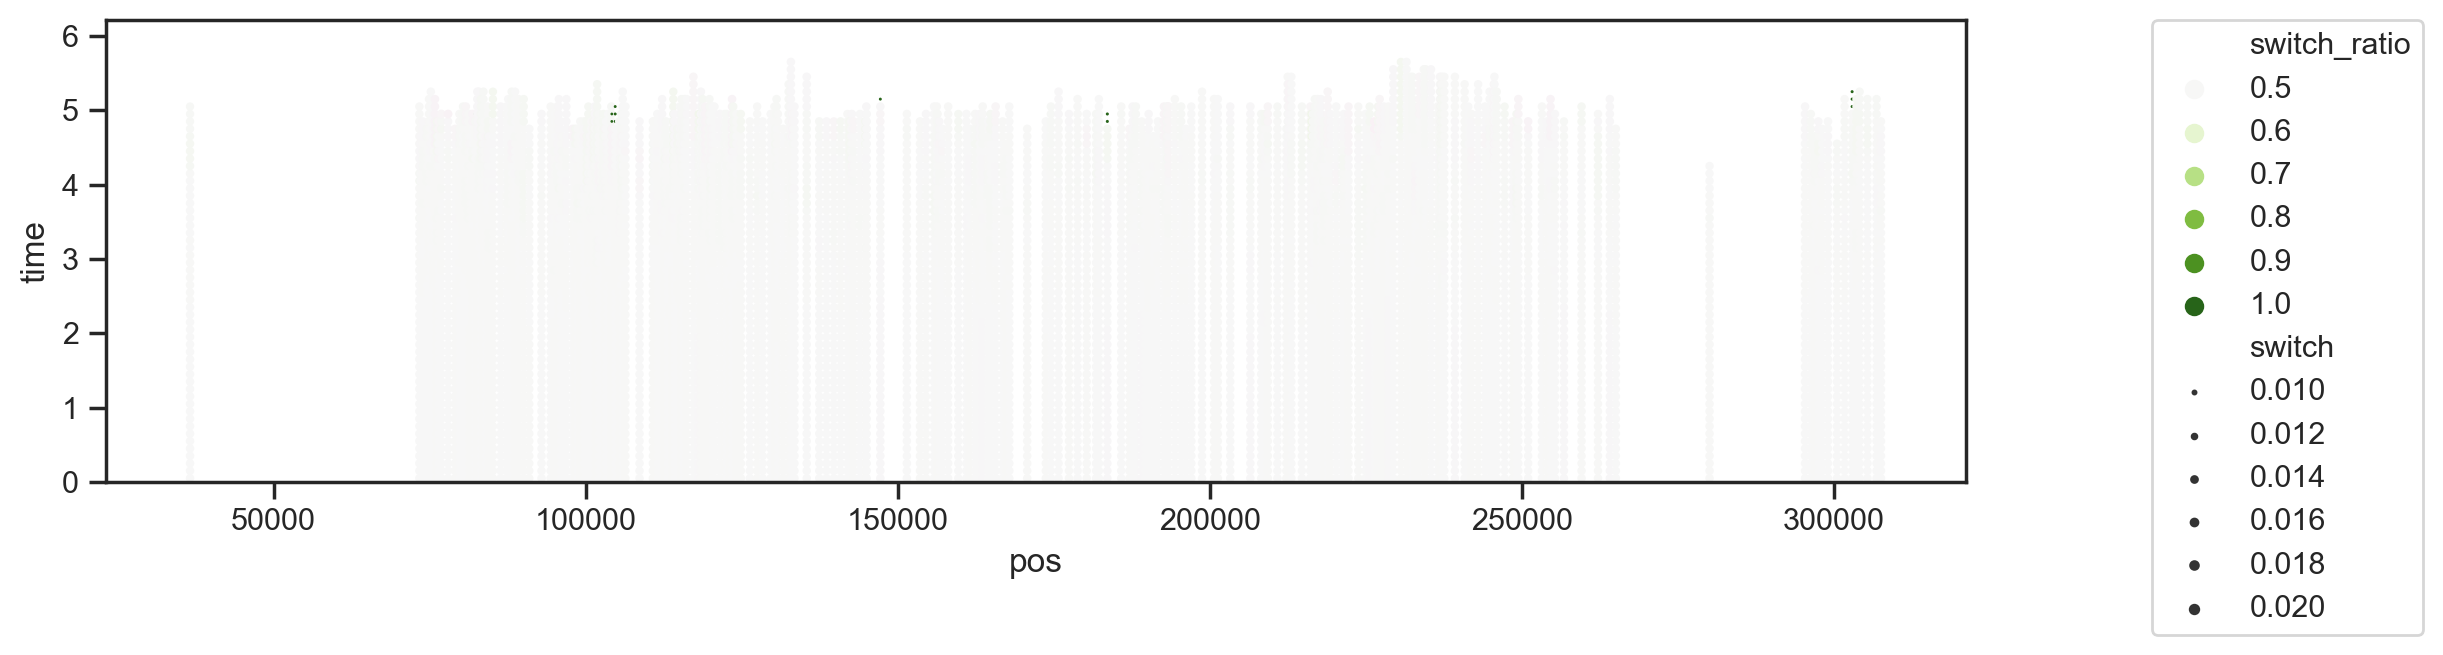

In [179]:
colors = sns.color_palette('PiYG', n_colors=10)
pink, green = colors[0], colors[-1]

with sns.color_palette('PiYG'), sns.axes_style('ticks'):
    fig, ax1 = plt.subplots(1, 1, figsize=(12,3))
    g = sns.scatterplot(data=plot_df, x='pos', y='time', hue='switch_ratio', size='switch',
        sizes=(1, 10), 
        palette='PiYG',
        hue_norm=(0, 1),
        ax=ax1, 
        legend='brief',
        linewidth=0)
    ax1.set_ylim(0, 1.1*plot_df.time.max())  
    ax1.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0)
       
    # ax2 = ax1.twinx()
    # ax2.plot(plot_df.pos, plot_df.mrca_0, '-x', color=pink, label='mrca 0')
    # ax2.plot(plot_df.pos, plot_df.mrca_1, '-x', color=green, label='mrca 1')
    # ax2.plot(plot_df.pos, plot_df.mrca_tree, '-x', color='black', label='mrca all')
    # ax2.set_ylim(0, 1.1*max(plot_df.mrca_tree.max(), plot_df.mrca_0.max(), plot_df.mrca_1.max()))
    # ax2.legend(bbox_to_anchor=(1.4, 1), loc='upper left', borderaxespad=0)




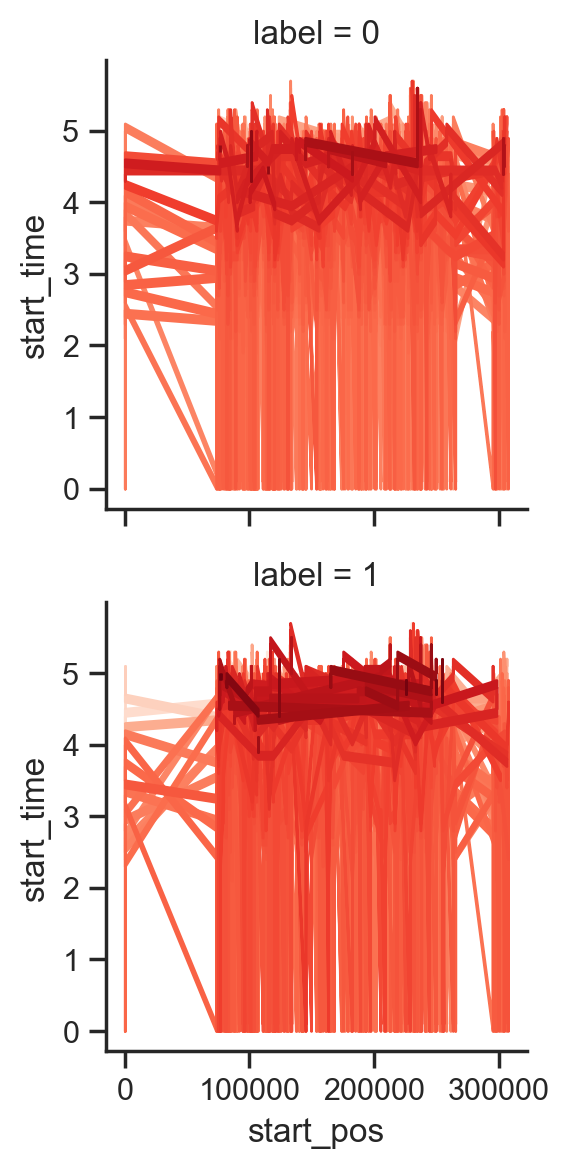

In [180]:
g = sns.FacetGrid(data=test_df, row='label', hue='switches', palette='Reds')
g.map(plt.fill_between, 'start_pos', 'start_time', 'end_time', label='label')

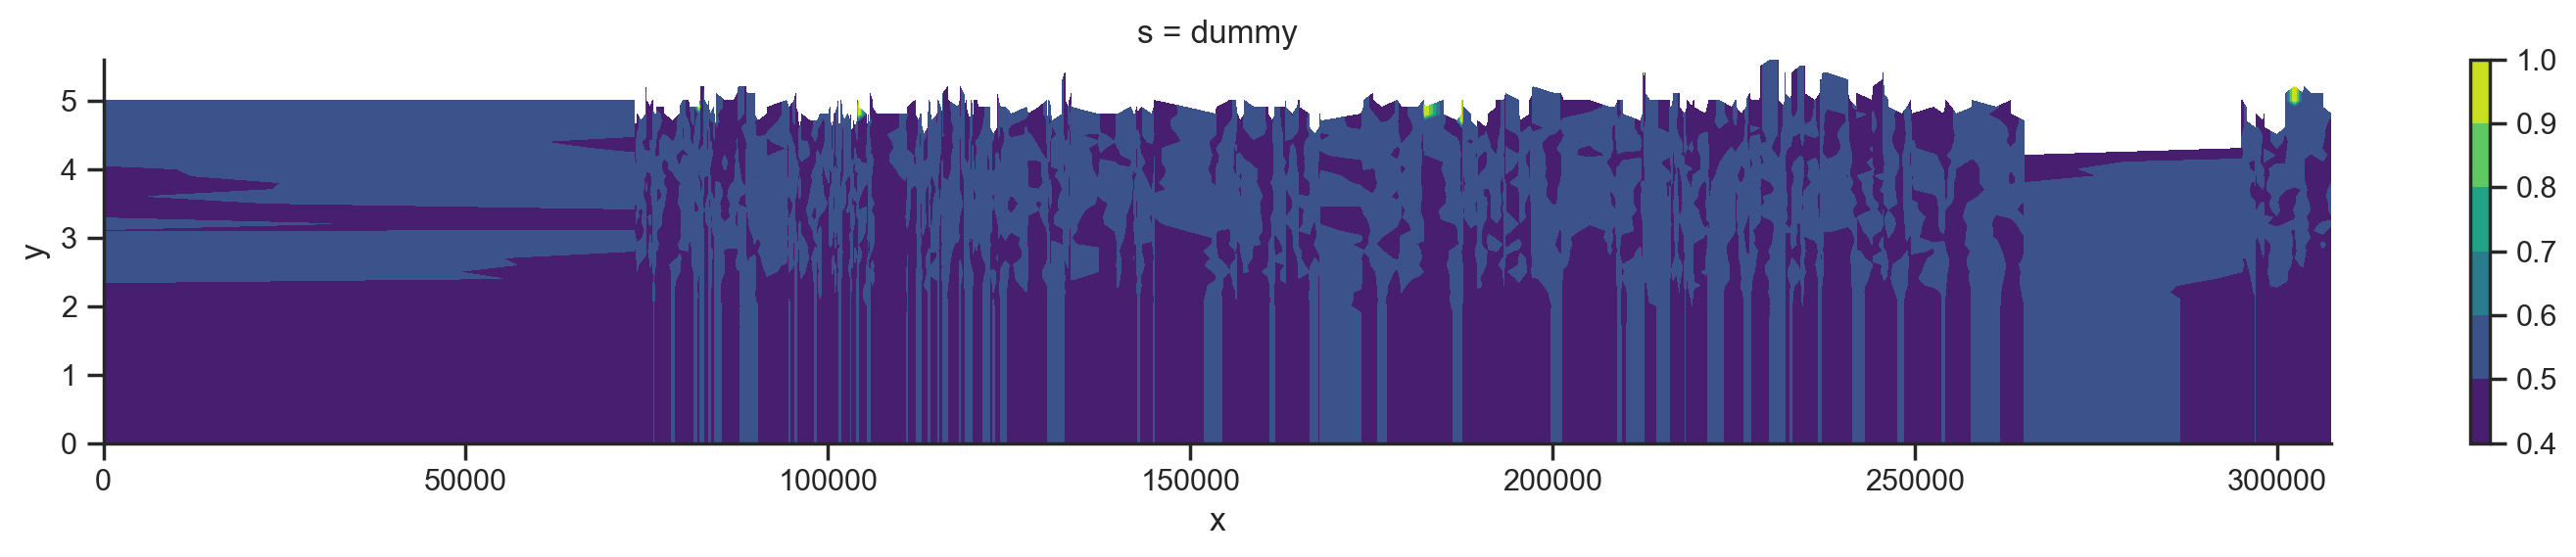

In [181]:
import numpy as np
import pandas
import seaborn as sns
from matplotlib import colors, cm

# x, y = np.meshgrid(np.linspace(0, 100), np.linspace(0, 100))

# df = pandas.DataFrame(dict(
#        x=np.r_[x.ravel(), x.ravel()],
#        y=np.r_[y.ravel(), y.ravel()],
#        s=np.r_[
#            np.ones_like(x.ravel()),
#            np.ones_like(x.ravel()) * 10
#        ]
# ))

df = pd.DataFrame(dict(
       x=plot_df.start_pos,
       y=plot_df.start_time,
       value=plot_df.switch_ratio
))
df = df.assign(s='dummy')

# df['value'] = (
#    df.x *
#    np.exp(-((df.x - df.y) ** 2 / df.s ** 2))
# )

g = sns.FacetGrid(df, row='s', aspect=5)

def contourplot(*args, **kwargs):

    # with warnings.catch_warnings(action='ignore', category=UserWarning):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        data = kwargs.pop("data").pivot(index=args[1], columns=args[0])[args[2]]
        X, Y = np.meshgrid(data.columns, data.index)
        ax = plt.gca()
        mappable = ax.contourf(X, Y, data, *args[3:],  
                               cmap='viridis',
                               # cmap='viridis', norm=colors.LogNorm(vmin=data.columns.min()+0.000001, vmax=data.columns.max()),
                               # cmap='viridis', norm=colors.CenteredNorm(),
                               **kwargs)
        ax.figure.colorbar(mappable)

g.map_dataframe(contourplot, 'x', 'y', 'value', 5) ;

x    y  s    value
0           0.0  0.0  0  0.00986
1           0.0  0.0  1  0.00993
2           0.0  0.1  0  0.00986
3           0.0  0.1  1  0.00993
4           0.0  0.2  0  0.00986
...         ...  ... ..      ...
50430  963146.0  4.8  1  0.00983
50431  963146.0  4.9  0  0.00961
50432  963146.0  4.9  1  0.01007
50433  963146.0  5.0  0  0.00963
50434  963146.0  5.0  1  0.01016

[50435 rows x 4 columns]

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

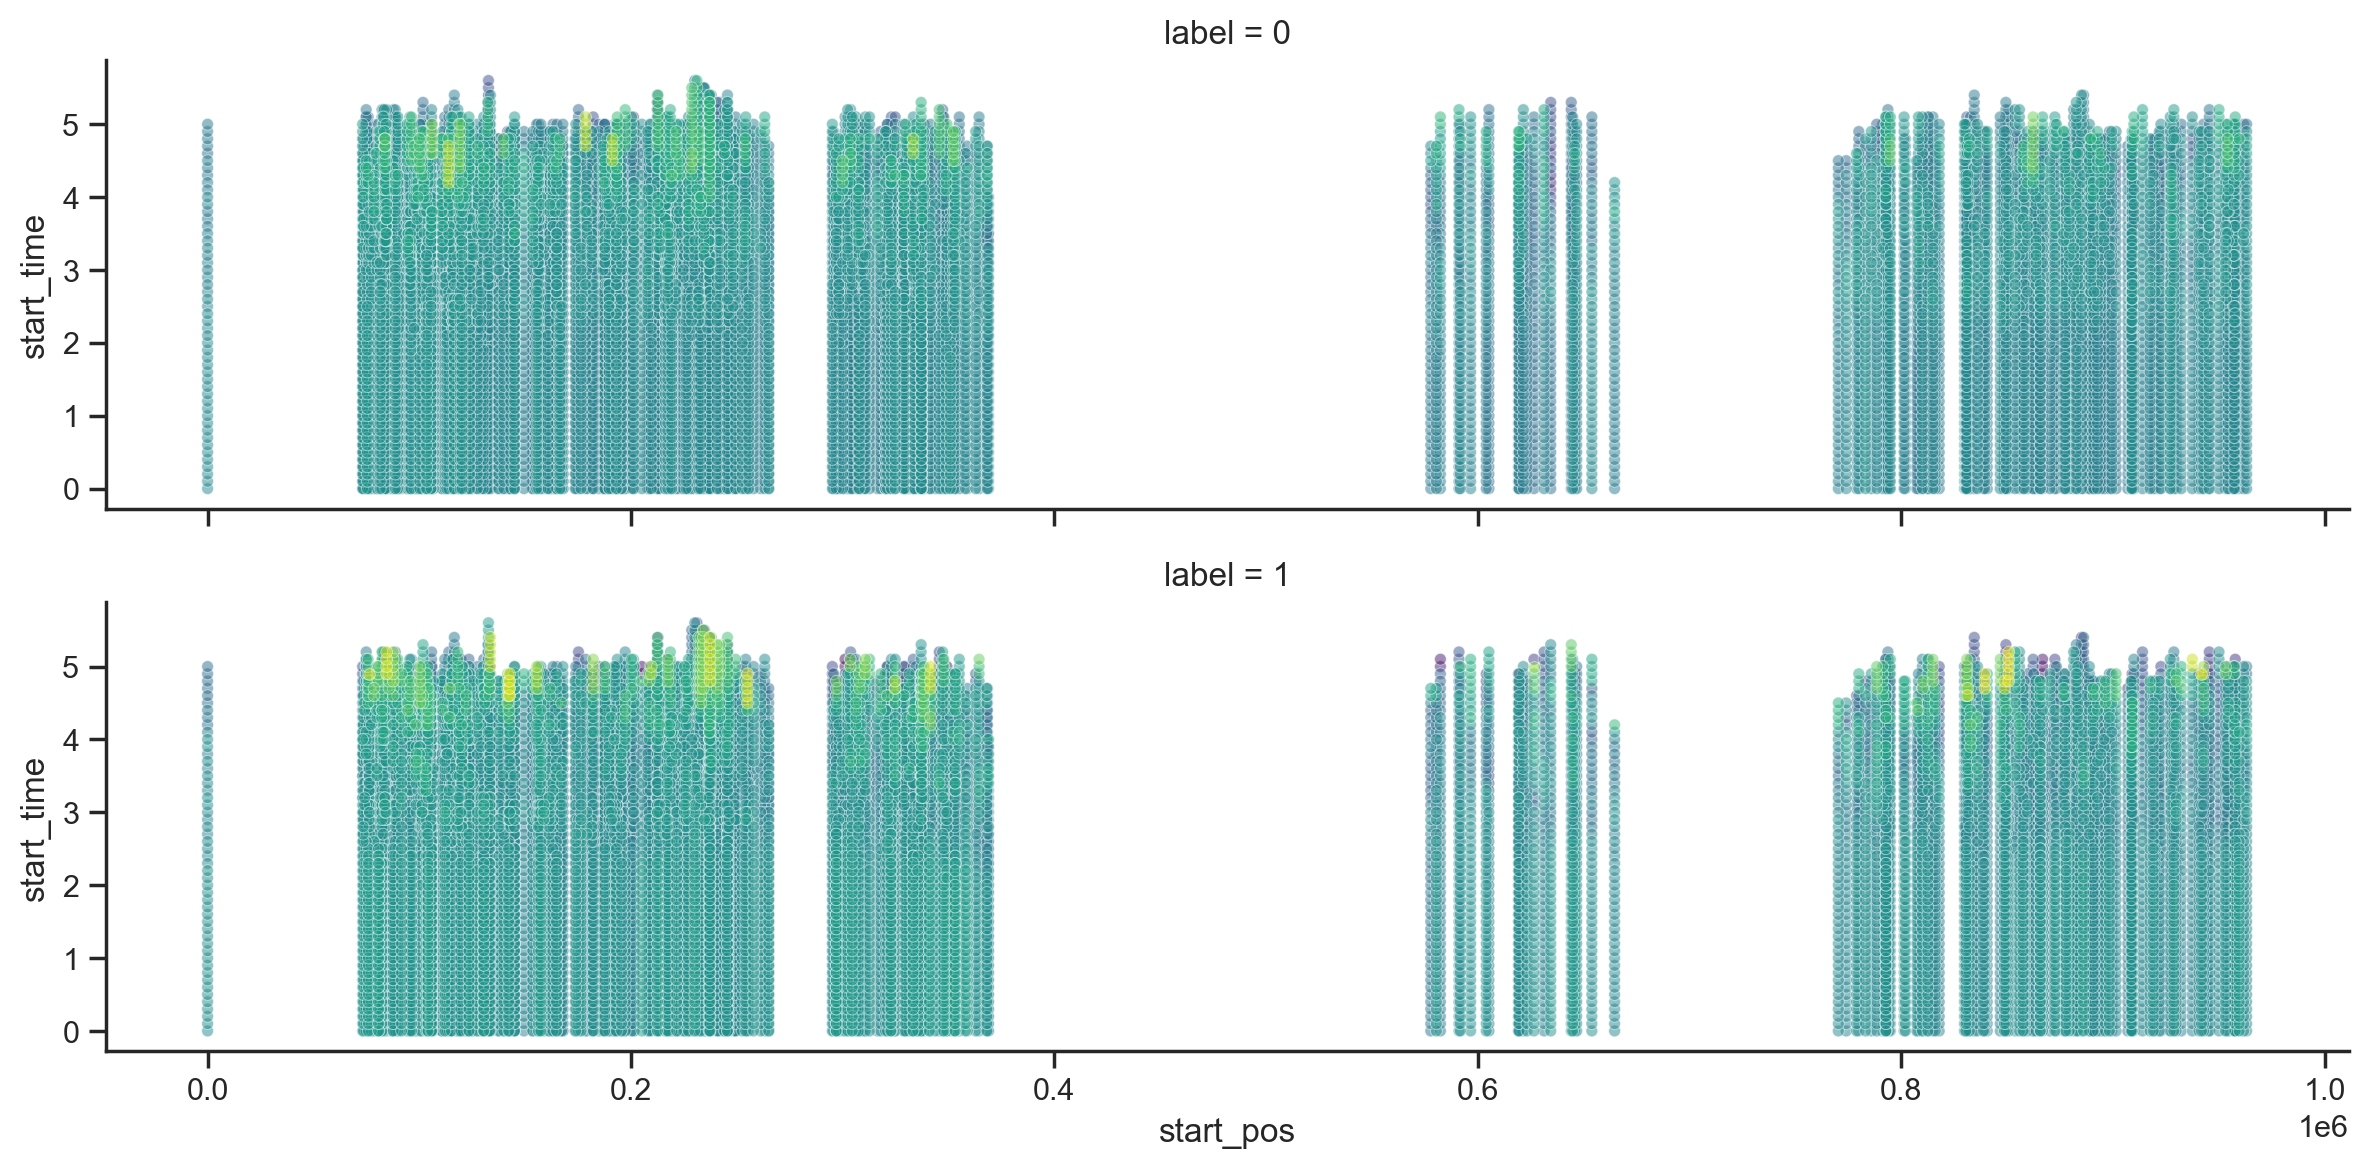

In [105]:
g = sns.FacetGrid(data=df, row='label', hue='switches', palette='viridis', aspect=4)
g.map(sns.scatterplot, 'start_pos', 'start_time', label='label', alpha=0.5, size=1, legend="full")
plt.colorbar()

#g.add_legend()
#g.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), ncol=1)
g.set(xlim=(0.06e6, 0.26e6)) ;

<AxesSubplot: xlabel='start_pos', ylabel='start_time'>

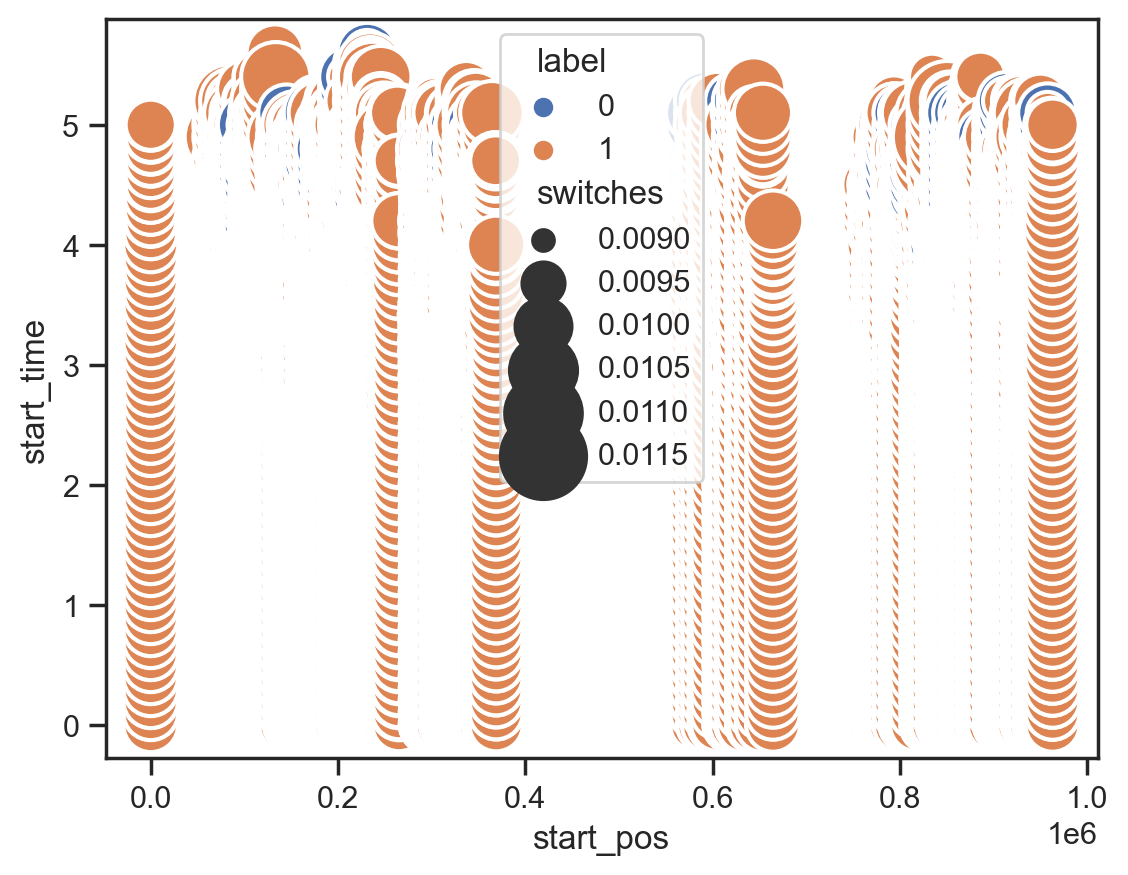

In [92]:
sns.scatterplot(data=df, x='start_pos', y='start_time', hue='label', size='switches',
sizes=(1, 1000), 
#hue_norm=(0, 7), 
#  legend="full"
 )

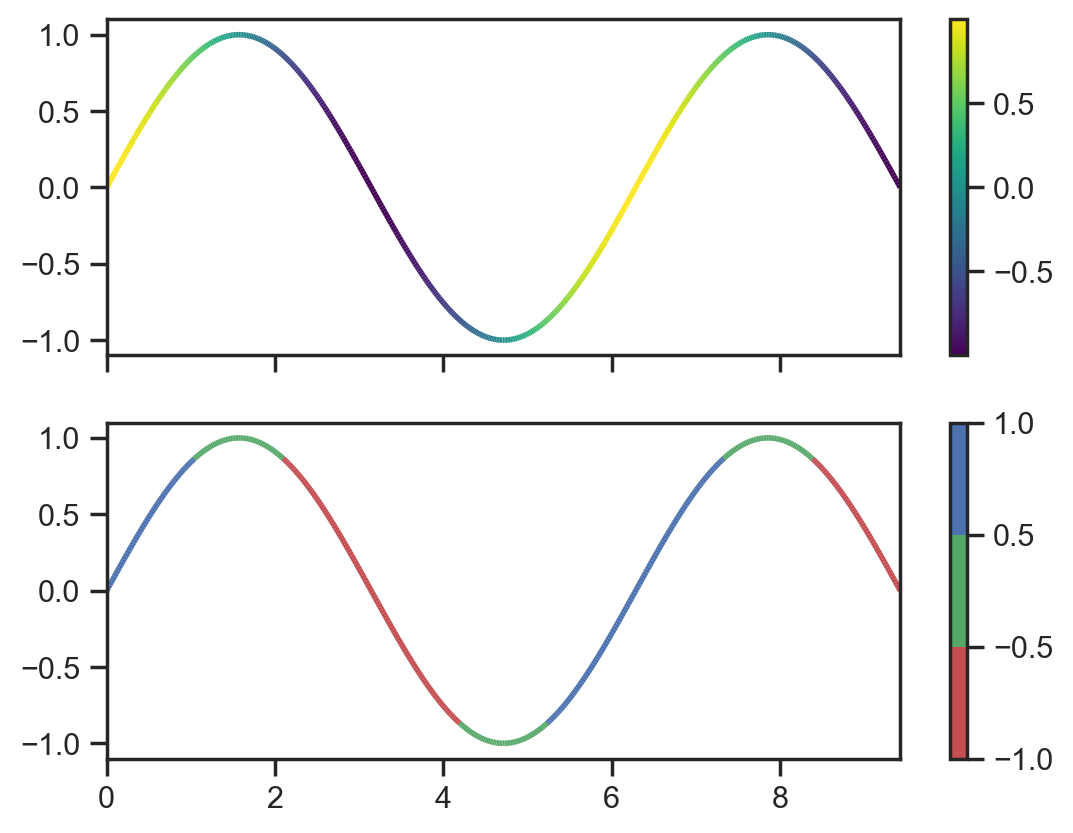

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

x = np.linspace(0, 3 * np.pi, 500)
y = np.sin(x)
dydx = np.cos(0.5 * (x[:-1] + x[1:]))  # first derivative

# Create a set of line segments so that we can color them individually
# This creates the points as a N x 1 x 2 array so that we can stack points
# together easily to get the segments. The segments array for line collection
# needs to be (numlines) x (points per line) x 2 (for x and y)
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

fig, axs = plt.subplots(2, 1, sharex=True, sharey=True)

# Create a continuous norm to map from data points to colors
norm = plt.Normalize(dydx.min(), dydx.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)
# Set the values used for colormapping
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs[0].add_collection(lc)
fig.colorbar(line, ax=axs[0])

# Use a boundary norm instead
cmap = ListedColormap(['r', 'g', 'b'])
norm = BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(dydx)
lc.set_linewidth(2)
line = axs[1].add_collection(lc)
fig.colorbar(line, ax=axs[1])

axs[0].set_xlim(x.min(), x.max())
axs[0].set_ylim(-1.1, 1.1)
plt.show()

In [103]:
import seaborn as sns

def masked_vs_unmasked_facets(output_dir, merged_df, target_col, thresholds):
    z_min = merged_df[['z_full', 'z_masked']].min(axis=0, skipna=True).min(skipna=True)
    z_max = merged_df[['z_full', 'z_masked']].max(axis=0, skipna=True).max(skipna=True)
    z_range_value = max(abs(z_min), abs(z_max))

    for i, val in enumerate(thresholds):
        merged_df.loc[merged_df.info_score_masked > val, 'PlotSet'] = i
        # Catch instances where there are no values in category, to ensure all facets are drawn each time
        if i not in merged_df['PlotSet'].unique():
            dummy_row = pd.DataFrame(columns=merged_df.columns, data={'PlotSet': [i]})
            merged_df = merged_df.append(dummy_row)

    g = sns.FacetGrid(merged_df, col='PlotSet', size=8)

    def facet_scatter(x, y, c, **kwargs):
        kwargs.pop("color")
        plt.scatter(x, y, c=c, **kwargs)

    vmin, vmax = 0, 1
    norm=plt.Normalize(vmin=vmin, vmax=vmax)

    g = (g.map(facet_scatter, 'z_full', 'z_masked', 'info_score_masked', norm=norm, cmap='viridis'))

    titles = ["Correlation for all masked / unmasked z-score with {} above {}".format(target_col, threshold) for threshold in thresholds]

    axs = g.axes.flatten()
    for i, ax in enumerate(axs):
        ax.set_title(titles[i])
        ax.set_xlim([-z_range_value * 1.1, z_range_value * 1.1])
        ax.set_ylim([-z_range_value * 1.1, z_range_value * 1.1])
        ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")


    cbar_ax = g.fig.add_axes([1.015,0.13, 0.015, 0.8])
    plt.colorbar(cax=cbar_ax)
    # extra_artists used here
    plt.savefig(os.path.join(output_dir, 'masked_vs_unmasked_scatter_final.png'), bbox_extra_artists=(cbar_ax,),  bbox_inches='tight')

masked_vs_unmasked_facets(output_dir, masking_results, 'info_score_masked', [0, 0.7, 0.9])


NameError: name 'output_dir' is not defined